In [52]:
import pandas as pd
import numpy as np
import scipy as sc
import statsmodels as stats
import matplotlib.pyplot as plt

# Simple OLS: Data Generation and Visualisation

**Goal:** create a clean synthetic dataset from a known linear Data Generating Process (DGP), visualise it, and set up the plan for estimating OLS in the next step.

## True DGP (single regressor)

We simulate $n=500$ observations from
$$
y_i \;=\; \beta_0 \;+\; \beta_1 x_i \;+\; \varepsilon_i,
$$
with $\beta_0=1.5$, $\beta_1=2.0$, and $\varepsilon_i \sim \mathcal{N}(0,1)$.
We draw $x_i \sim \mathcal{N}(0,1)$ independently of $\varepsilon_i$.


We now set the seed for the random function inside `numpy` so that we can reproduce our results each time we run the notebook.

Note that, for each seed, the estimates we will get will be slightly different. This is because the string of random numbers which generates the data will be different each time.

In [53]:
rs = np.random.RandomState(123)
#rs = np.random.RandomState(456)

Also, note that increasing the number of data points will improve the estimate of the DGP.

In [54]:
#n = 500
n = 5000
x1 = rs.normal(0, 1, n)
x2 = rs.normal(0, 1, n)

beta0, beta1= 1.5, 2.0
eps = rs.normal(0, 1, n)

y = beta0 + beta1 * x1 + eps

In [55]:
df = pd.DataFrame({"y": y, "x1": x1})
df.head()

,y,x1
0,-1.912231,-1.085631
1,3.181744,0.997345
2,1.217010,0.282978
3,0.865363,-1.506295
4,1.000300,-0.578600


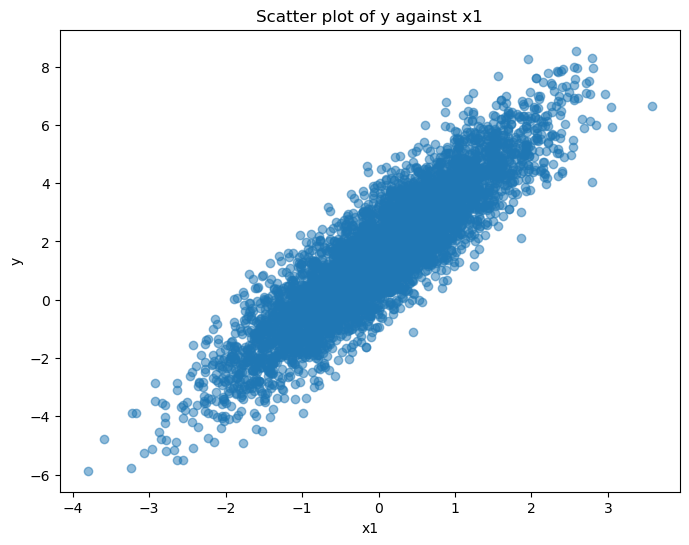

In [56]:
fig = plt.figure(figsize=(8,6))

plt.scatter(df['x1'], df['y'], alpha=0.5)
plt.xlabel('x1')
plt.ylabel('y')
plt.title('Scatter plot of y against x1')

plt.show()

### Equivalent Cov/Var formulas (simple regression)

In the simple regression with one regressor $x$, the OLS slope and intercept have the closed forms
$$
\hat\beta_1 \;=\; \frac{\sum_{i=1}^n (x_i-\bar x)(y_i-\bar y)}{\sum_{i=1}^n (x_i-\bar x)^2}
\;=\; \frac{\operatorname{Cov}(x,y)}{\operatorname{Var}(x)},
\qquad
\hat\beta_0 \;=\; \bar y \;-\; \hat\beta_1 \bar x.
$$

**Sampling variances (given $X$):**
$$
\operatorname{Var}(\hat\beta_1 \mid X) \;=\; \frac{\sigma^2}{\sum_{i=1}^n (x_i-\bar x)^2},
\qquad
\operatorname{Var}(\hat\beta_0 \mid X) \;=\;
\sigma^2\!\left(\frac{1}{n} + \frac{\bar x^{\,2}}{\sum_{i=1}^n (x_i-\bar x)^2}\right).
$$

**Plug-in standard errors (replace $\sigma^2$ by $\widehat{\sigma}^2$):**
$$
\widehat{\sigma}^2 \;=\; \frac{\sum_{i=1}^n \hat\varepsilon_i^2}{n-2},\quad
\hat\varepsilon_i = y_i - \hat\beta_0 - \hat\beta_1 x_i,
$$
$$
\operatorname{SE}(\hat\beta_1) \;=\; 
\sqrt{\;\widehat{\sigma}^2 \Big/ \sum_{i=1}^n (x_i-\bar x)^2\;},\qquad
\operatorname{SE}(\hat\beta_0) \;=\;
\sqrt{\;\widehat{\sigma}^2\!\left(\frac{1}{n} + \frac{\bar x^{\,2}}{\sum_{i=1}^n (x_i-\bar x)^2}\right)}.
$$

## OLS / BLUE more generally

Model:
$$
y_i = \beta_0 + \beta_1 x_i + \varepsilon_i,\quad i=1,\dots,n,
$$
with $ \mathbb{E}[\varepsilon_i \mid x_i]=0 $, homoscedastic variance, and no autocorrelation.

Stacked form $y = X\beta + \varepsilon$, where $X = [\mathbf{1}\; x]$ and $\beta=(\beta_0,\beta_1)'$.

**OLS (BLUE) estimator:**
$$
\hat\beta = (X^\top X)^{-1}X^\top y.
$$

**Variance & SEs (estimated):**
$$
\widehat{\sigma}^2 \;=\; \frac{\hat\varepsilon^\top \hat\varepsilon}{n-k},\qquad
\widehat{\operatorname{Var}}(\hat\beta \mid X) \;=\; \widehat{\sigma}^2 (X^\top X)^{-1},\qquad
\text{SE}(\hat\beta_j) \;=\; \sqrt{\,[\widehat{\sigma}^2 (X^\top X)^{-1}]_{jj}}.
$$

with $k=2$ here (intercept + slope).


We’ll estimate $\hat\beta$ three ways:
1) **NumPy** closed-form $(X'X)^{-1}X'y$
2) **SciPy** by minimizing SSR
3) **statsmodels** OLS (classic and HC1 robust SEs)

**Step 1:** Build the design matrix $X$ and the response $y$

In [57]:
# 1) Pull numpy arrays out of the DataFrame
y = df["y"].to_numpy()       # Shape (n,)  
x = df["x1"].to_numpy()      # Shape (n,)

In [58]:
# 2) Build the design matrix: first column of ones (intercept), second column is x
X = np.column_stack([np.ones(len(df)), x])

In [59]:
# Sanity check the shapes (good habit)
n, k = X.shape
print(f"n (rows) = {n}, k (columns) = {k}") 

n (rows) = 5000, k (columns) = 2


**Step 2:** OLS with `numpy`

In [60]:
# 1) Compute (X'X) and (X'y)
XtX = X.T @ X
Xty = X.T @ y

In [61]:
# 2) Closed-form OLS: beta_hat = (X'X)^(-1) (X'y)
beta_hat_np = np.linalg.inv(XtX) @ Xty

In [62]:
print("NumPy OLS coefficients:")
print(f"  beta0_hat (intercept) = {beta_hat_np[0]:.4f}")
print(f"  beta1_hat (slope)     = {beta_hat_np[1]:.4f}")

NumPy OLS coefficients:
  beta0_hat (intercept) = 1.5254
  beta1_hat (slope)     = 2.0149


In [63]:
# 3) Residuals (observed minus fitted)
resid = y - X @ beta_hat_np # Shape (n,)

In [64]:
# 4) Residual variance (unbiased): sigma^2_hat = SSR / (n - k)
SSR = resid @ resid
sigma2_hat = SSR / (n - k)

In [65]:
# 5) Variance-covariance of beta_hat: Var(beta) = sigma^2_hat * (X'X)^(-1)
Var_beta = sigma2_hat * np.linalg.inv(XtX)

In [66]:
# 6) Standard errors are the square roots of the diagonal
se_np = np.sqrt(np.diag(Var_beta))

In [67]:
print("\nNumPy OLS standard errors (classic):")
print(f"  SE(beta0_hat) = {se_np[0]:.4f}")
print(f"  SE(beta1_hat) = {se_np[1]:.4f}")


NumPy OLS standard errors (classic):
  SE(beta0_hat) = 0.0142
  SE(beta1_hat) = 0.0143


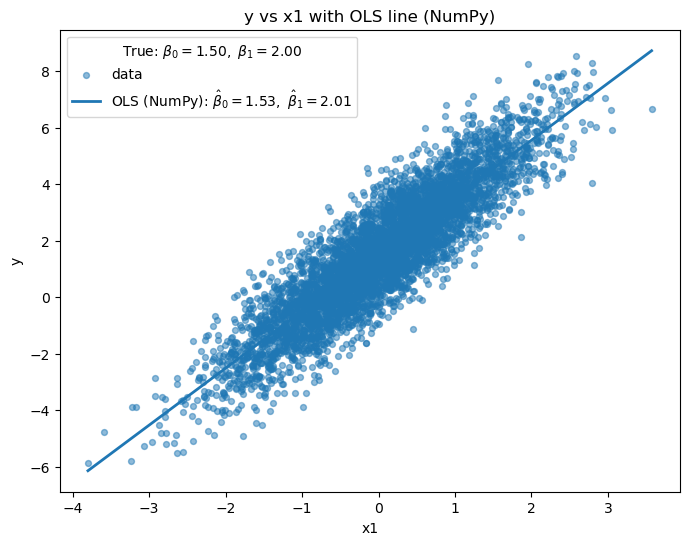

In [68]:
# True parameters from the DGP
beta0_true, beta1_true = 1.5, 2.0

# Grid for a smooth line
xgrid = np.linspace(df["x1"].min(), df["x1"].max(), 200)

# Fitted line using NumPy estimates (assumes beta_hat_np already computed)
yfit_np = beta_hat_np[0] + beta_hat_np[1] * xgrid

# Legend labels with coefficients
label_true = rf"True: $\beta_0={beta0_true:.2f},\ \beta_1={beta1_true:.2f}$"
label_np   = rf"OLS (NumPy): $\hat{{\beta}}_0={beta_hat_np[0]:.2f},\ \hat{{\beta}}_1={beta_hat_np[1]:.2f}$"

plt.figure(figsize=(8,6))
plt.scatter(df["x1"], df["y"], alpha=0.5, s=18, label="data")
plt.plot(xgrid, yfit_np, linewidth=2, label=label_np)

plt.xlabel("x1")
plt.ylabel("y")
plt.title("y vs x1 with OLS line (NumPy)")
plt.legend(title=label_true, frameon=True, fontsize=10)
plt.show()